# Self Organized Maps (SOMs) for DES/VIKING/CATWISE objects

## Define the directory

In [1]:
observatory = '/data/mfonseca/'
my_computer = '/home/polaris/Lab_Astro/data/'

directory = my_computer

## Import Libraries

In [3]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np
import pandas as pd

# SimpSOM, https://simpsom.readthedocs.io
import simpsom as sps

# Astropy
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u

# CuPY
# import cupy as cp

# Seaborn
import seaborn as sns

# Kolmorgorov-Smirnov
from scipy.stats import kstest

## PCA Whitening and ZPCA Whitening

In [ ]:
def pca_whitening(data, epsilon=1e-5):
    '''
    PCA whitening

    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data pca whitened
    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(data, axis=0)
    data_centered = data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_centered, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

  
    D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + epsilon))
    whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T

    xPCAwhite = (whitening_matrix @ data_centered.T).T

    return xPCAwhite


def zca_whitening(data, epsilon=1e-5):
    '''
    ZCA whitening
    
    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data zca whitened

    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(data, axis=0)
    data_mean0 = data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_mean0, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Calculate x_rot and x_tilde
    x_rot = np.dot(data_mean0, eigvecs)

    # Whitening matrix: U * D^{-1/2} * U.T
    D_inv_sqrt = np.diag(1.0 / np.sqrt(eigvals + epsilon))
    whitening_matrix = eigvecs @ D_inv_sqrt @ eigvecs.T

    # Apply whitening
    xZCAwhite = data_mean0 @ whitening_matrix
    
    return xZCAwhite

## PCA Dewhitening and ZCA Dewhitening

In [ ]:
def inverse_pca_whitening(original_data, whitened_data, epsilon=1e-5):
    '''
    Inverse PCA whitening

    Args:
        original_data: original data
        whitened_data: whitened data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data in original feature space
    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(original_data, axis=0)
    data_centered = original_data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_centered, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    D_sqrt = np.diag(np.sqrt(eigvals + epsilon))

    
    # Calculate the inverse of the PCA whitening matrix
    X_centered = whitened_data @ ((eigvecs @ D_sqrt @ eigvecs.T))
    
    x_dewhitened = X_centered + data_mean.values

    return x_dewhitened


def inverse_zca_whitening(original_data, whitened_data, epsilon=1e-5):
    '''
    Inverse ZCA whitening
    
    Args:
        data: array-like data
        epsilon: small value to avoid division by zero

    Returns:
        out: array-like data in original feature space

    
    '''
    # Data needs to have 0 mean
    data_mean = np.mean(original_data, axis=0)
    data_mean0 = original_data - data_mean

    # If the data has 0 mean, then we calculate the covariance matrix
    # rowvar=False means that each row is an observation
    cov_matrix = np.cov(data_mean0, rowvar=False)

    # Calculate the eigenvalues and the eigenvectors
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Calculate the inverse of the ZCA whitening matrix
    D = np.diag(np.sqrt(eigvals + epsilon))
    inverse_zca_matrix = eigvecs @ D @ eigvecs.T

    # Apply inverse transform and add mean back
    x_orig = (inverse_zca_matrix @ whitened_data.T).T + data_mean.values

    return x_orig


# Import DES + VIKING + CATWISE match catalog

Import the matched catalog from NWAY and convert it to a Pandas DataFrame.

In [6]:
# RADIUS (3''), DESY6GOLD (0.1''), VIKINGDR4 (0.1''), CATWISE2020 (0.2''), No MAGNITUDES
# For a false detection rate of <10% 
# p_i>=0.1 & match_flag==1 & p_any>0.81
matched_no_mags_path = directory + 'cross_match/without_EMU/DESY6_VKG_CAT_noMags/DESY6_VKG_CAT_noMags.fits'
matched_no_mags = Table.read(matched_no_mags_path)
matched_no_mags = matched_no_mags.to_pandas()

Filter using NWAY recomendations

In [9]:
# Here we filter the NWAY catalog to keep only the best objects

# From NWAY
# Filter the catalog based on the match_flag and p_i, p_any values
match_mask = (matched_no_mags['match_flag'] == 1) & (matched_no_mags['p_i'] >= 0.1) & (matched_no_mags['p_any'] >= 0.81)
catalog_matches_noMags = matched_no_mags[match_mask]
print(f'Number of objects in the catalog {len(catalog_matches_noMags)}')

Number of objects in the catalog 12000


Select the objects that have matches in the two surveys

In [10]:
# Here we select objects that have matches in all three surveys
full_match_mask = ((catalog_matches_noMags['VKG_sourceID'] != -99) & (catalog_matches_noMags['CAT_source_id'] != b'-99'))
catalog_matches_noMags_full = catalog_matches_noMags[full_match_mask]
print(f'Number of objects in the catalog that have matches in the two surveys {len(catalog_matches_noMags_full)}')

Number of objects in the catalog that have matches in the two surveys 4879


Select the features used in the SOM

In [ ]:
som_columns = ['DESY6_mag_auto_g_extcorr',
                   'VKG_mag_petro_y_ab_extcorr',
                   'CAT_w1mpro_ab',
                   'DESY6_g_r_extcorr', 
                   'DESY6_r_i_extcorr', 
                   'DESY6_i_z_extcorr', 
                   'VKG_y_j_petro_extcorr', 
                   'VKG_j_h_petro_extcorr', 
                   'VKG_h_ks_petro_extcorr', 
                   'CAT_w1_w2_ab', 
                   'DESY6_spread_model_g']

catalog_som = catalog_matches_noMags_full[som_columns]

Filter for objects that have full photometric coverage in all the bands

In [ ]:
# All the photometric values that weren't detected are nans
catalog_som = catalog_som.dropna()

print(len(catalog_som))
catalog_som.describe()

# Perform ZCA Whitening

Correlation matrix for original data

In [ ]:
correlation_matrix_original = catalog_som.corr(method='pearson')
plt.figure(figsize = (9,8))
sns.heatmap(correlation_matrix_original, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.title("Pearson Correlation Matrix for Original Data")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Correlation matrix for ZCA whitened data

In [ ]:
# Save the original training data to an CSV file for easier access
data_path = '/home/polaris/Lab_Astro/data/soms/maps1/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_original.csv'
data.to_csv(data_path, index=False)


# ZCA Whiten the data
data_white = zca_whitening(data)

# Keep the column labels
data_white.columns = som_columns[:data_white.shape[1]]

# Save the ZCA Whitened to an CSV file for easier access
data_white_path = '/home/polaris/Lab_Astro/data/soms/maps1/EMU_0102-32_DESY6GOLD_VIKINGDR5_CATWISE_noMag_zcaWhite.csv'
data_white.to_csv(data_white_path, index=False)

# Calculate and plot the correlation matrix for the ZCA Whitened data
correlation_matrix_whitened = data_white.corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(correlation_matrix_whitened, annot=True, fmt=".2f", cmap='coolwarm', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.75})

plt.title("Pearson Correlation Matrix ZCA Whitened Data")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Generate the SOMs

## Define the SOM topology

In [ ]:
# SOM topology (lattice size)

data_white = np.array(data_white)

# Number of sources in our dataframe
inputdata_size = len(data_white)

# From Kohonen, the optimal ratio of height to width of the lattice
# is equal to the ratio of the two largest eigenvalue of the autocorrelation matrix
cov_matrix = np.cov(data_white, rowvar=False)
eigen_values = np.linalg.eigvals(cov_matrix)
eigen_values_sorted = np.sort(eigen_values)[::-1]
ratio_eigenvalues = eigen_values_sorted[0] / eigen_values_sorted[1]

# From Kohonen, the number of nodes is 5*sqrt(n), where n is the number of data points
som_dim = int(np.sqrt(inputdata_size) * 5)

# The number of nodes in the x and y direction
som_x = int(np.sqrt(som_dim * ratio_eigenvalues))
som_y = int(som_x / ratio_eigenvalues)

#=================================================================

# Resize the SOM map by applying a scaling factor that maintains the aspect ratio

scaling_factor = 2  # Change this factor to resize the map

# Apply scaling to the x dimension, and calculate y dimension based on ratio
som_x_resized = int(som_x * scaling_factor)
som_y_resized = int(som_x_resized / ratio_eigenvalues)  # Keep the same ratio of eigenvalues

#=================================================================

# Print the results
print('Dimension of the SOM: ', som_dim)
print('Square SOM map size ', np.round(np.sqrt(som_dim)))
print('Ratio of the two largest eigenvalues: ', int(ratio_eigenvalues))
print('SOM map size using eigenvalues: ', som_x, 'x', som_y)

print('Resized SOM map size using eigenvalues: ', som_x_resized, 'x', som_y_resized)

## Run the SOM

In [ ]:
# Define the SOM
som = sps.SOMNet(
    som_x,
    som_y,
    data_white,
    load_file = None,
    metric = 'euclidean', # 'euclidian' or 'cosine' or 'manhattan'
    # metrick_kwds={},
    init = 'random' , # 'random' or 'pca'
    PBC = True,
    GPU = False,
    random_seed = 6942,
    topology='hexagonal', # 'square' or 'hexagonal'
    debug= True,
    output_path = '/home/polaris/Lab_Astro/data/soms/maps4/epoch_files'
)

# Train the SOM
som.train(
    train_algo = 'batch', 
    epochs = 100,
    # start_learning_rate = 0.01 , # Used only for online training
    early_stop = None ,
    early_stop_patience = 3 ,
    early_stop_tolerance = 0.01 ,
    batch_size = -1
)

## Quality check: Quantization Error and Topographic Error

In [7]:
quantization_error_list = [16.73721694946289, 2.8538708686828613, 2.8346457481384277, 2.817385196685791, 2.8009862899780273, 2.788602828979492, 2.777346611022949, 2.767371416091919, 2.757256507873535, 2.7473373413085938, 2.7368361949920654, 2.7259304523468018, 2.7143826484680176, 2.702284336090088, 2.689603090286255, 2.676363229751587, 2.662564992904663, 2.6481943130493164,2.633239507675171,2.6176836490631104,2.601508855819702, 2.5846917629241943,2.5672237873077393,2.5490834712982178,2.5302553176879883,2.510720729827881,2.490475654602051,2.4695394039154053, 2.4479317665100098, 2.4256763458251953, 2.402820587158203, 2.3794214725494385, 2.355565309524536, 2.331327199935913]
topographic_error_list = [1.0, 0.041102589689299474, 0.23366567820686424, 0.15733754724394977, 0.07837477985803498, 0.1348611586181162, 0.09468860689358838, 0.09468860689358838,  0.1292950651450605, 0.1110307025602899, 0.12890495803521707, 0.12338974809822789, 0.13147457660657702, 0.13153394073198799, 0.1350166360894306, 0.13651204667716377, 0.13850498517310295, 0.13874809540097643, 0.13969226768132204, 0.1399325510460807, 0.14074386076003043, 0.14095870235675578, 0.14082301292724497, 0.14123856180512173, 0.14196223876251235, 0.14301948556745037, 0.14407107864615876, 0.14533468645847758, 0.14718345493556162, 0.14856579099870248, 0.14977286154872527, 0.1508159740380891, 0.15214742656516345, 0.15243859346598865]

34
34


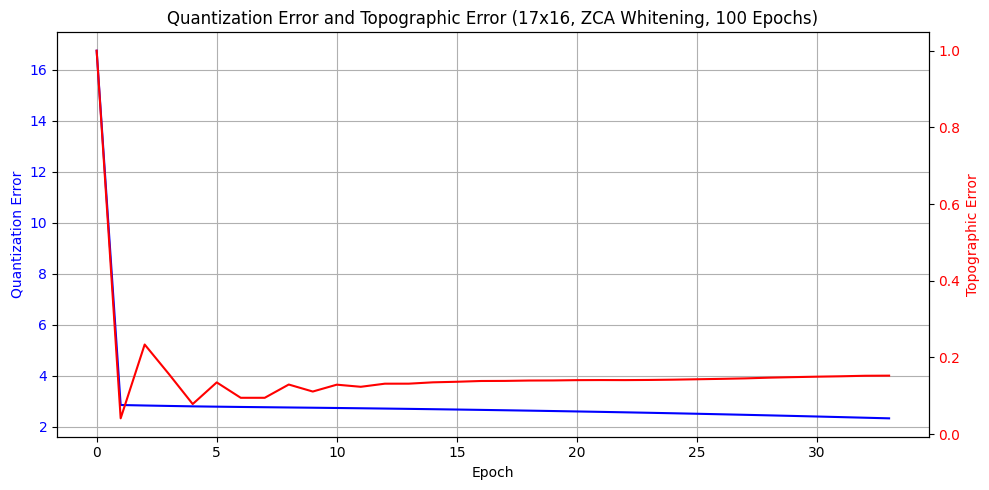

In [8]:
print(len(quantization_error_list))
print(len(topographic_error_list))

fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot Quantization Error on the primary y-axis
ax1.plot(quantization_error_list, label='Quantization Error', color='blue')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Quantization Error', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.tick_params(axis='x', labelcolor='black')
ax1.grid()

# Create a secondary y-axis for Topographic Error
ax2 = ax1.twinx()
ax2.plot(topographic_error_list, label='Topographic Error', color='red')
ax2.set_ylabel('Topographic Error', color='red')
ax1.tick_params(axis='x', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='red')

plt.title('Quantization Error and Topographic Error (17x16, ZCA Whitening, 100 Epochs)')
fig.tight_layout()
plt.show()

## Prototypes

Select the best epoch - lowest quantization error and topographic error and plot the U matrix

### Prototype maps after dewhitening

### Comparison of prototype values with original values

In [ ]:
num_cols = 6
num_rows = 3        
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(12, 6))
axes = axes.flatten()  # Flatten the 2D array of axes for easy indexing

for i, col in enumerate(som_columns):
    if i < len(axes):
        ax = axes[i]
        original_data = catalog_som[col]
        som_column_data = [weights_dewhitened[row][som_columns.index(col)] for row in range(len(weights_dewhitened))]

        # Histogram of the original data
        ax.hist(original_data, weights=np.ones(len(original_data)) / len(original_data), bins=100, alpha=0.6, label='Original Data', color='skyblue')

        # Histogram of the dewhitened prototypes
        ax.hist(som_column_data, weights=np.ones(len(som_column_data)) / len(som_column_data), bins=100, alpha=0.6, label='SOM Prototypes', color='red')

        # Kolmogorov-Smirnov test: how similar are the distributions?
        ks_statistic, p_value = kstest(original_data, som_column_data)
        ax.set_title(f'{col}\nKS Statistic: {ks_statistic:.2f}, p-value: {p_value:.3f}', fontsize=8)


        ax.set_xlabel('Values', fontsize=7)
        ax.set_ylabel('Probability Density', fontsize=7)
        ax.legend(fontsize=6)
        ax.grid(True, alpha=0.5)
        ax.tick_params(axis='both', which='major', labelsize=5)

# Remove any unused subplots
if len(som_columns) < len(axes):
    for j in range(len(som_columns), len(axes)):
        fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Photometry of prototypes

Find the data points for each node and construct a dictionary for each.

In [ ]:
# simpsom.network.SOMNode object at 'hexcode'
nodes = best_som.nodes_list

print(nodes)
bmus = best_som.find_bmu_ix(data_white)
print(bmus)

nodes_data_dict = {}

# Key= node object, Value = data index
for node in nodes:
    node_indices = [idx for idx in range(len(data_white)) if nodes[bmus[idx]] == node]
    nodes_data_dict[node] = node_indices

print(nodes_data_dict)

Convert the colors to fluxes, define the errors as the median value of the errors of the data points

In [ ]:
# Create a dataframe with the weights for easier access
all_weights = [[node.weights[feature_idx] for feature_idx in range(len(som_columns))] for node in som.nodes_list]

prototypes_df = pd.DataFrame(all_weights, som_columns)

######################################################################################################################################
prototypes_df['id'] = ['node ' + str(idx) for idx in range(len(all_weights))]
prototypes_df['redshift'] = [-1 for _ in range(len(all_weights))]

######################################################################################################################################
# Convert the colors to magnitudes and then to fluxes
# DES
prototypes_df['ctio.decam.g'] = 10 ** (6.56-0.4 * [])
prototypes_df['ctio.decam.r'] = 10 ** (6.56-0.4 * [])
prototypes_df['ctio.decam.i'] = 10 ** (6.56-0.4 * [])
prototypes_df['ctio.decam.z'] = 10 ** (6.56-0.4 * [])

# VIKING
prototypes_df['paranal.vircam.Y'] = 10 ** (6.56-0.4 * [])
prototypes_df['paranal.vircam.J'] = 10 ** (6.56-0.4 * [])
prototypes_df['paranal.vircam.H'] = 10 ** (6.56-0.4 * [])
prototypes_df['paranal.vircam.Ks'] = 10 ** (6.56-0.4 * [])

# CATWISE
prototypes_df['wise.W1'] = 10 ** (6.56-0.4 * [])
prototypes_df['wise.W2'] = 10 ** (6.56-0.4 * [])

######################################################################################################################################
# Calculate the errors (10% of the fluxes)
# DES
prototypes_df['ctio.decam.g_err'] = prototypes_df['ctio.decam.g'] * 0.1
prototypes_df['ctio.decam.r_err'] = prototypes_df['ctio.decam.r'] * 0.1
prototypes_df['ctio.decam.i_err'] = prototypes_df['ctio.decam.i'] * 0.1
prototypes_df['ctio.decam.z_err'] = prototypes_df['ctio.decam.z'] * 0.1

# VIKING
prototypes_df['paranal.vircam.Y_err'] = prototypes_df['paranal.vircam.Y'] * 0.1
prototypes_df['paranal.vircam.J_err'] = prototypes_df['paranal.vircam.J'] * 0.1
prototypes_df['paranal.vircam.H_err'] = prototypes_df['paranal.vircam.H'] * 0.1
prototypes_df['paranal.vircam.Ks_err'] = prototypes_df['paranal.vircam.Ks'] * 0.1

# CATWISE
prototypes_df['wise.W1_err'] = prototypes_df['wise.W1'] * 0.1
prototypes_df['wise.W2_err'] = prototypes_df['wise.W2'] * 0.1

######################################################################################################################################
# Save the dataframe
prototypes_file_path = directory + 'soms/maps1/prototypes.fit'
prototypes_table = Table.from_pandas(prototypes_df)
prototypes_table.write('', overwrite=True)